# CONFIG

In [4]:
import streamlit as st
import sqlalchemy as db
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import time
from datetime import datetime
import textwrap

# DATA STRUCTURING

### Q1 DATA

In [5]:
#connect to the SQL database
connection = sqlite3.connect('bce.db')
#query tables
sql_query_Q1T1 = pd.read_sql_query ('''
                                SELECT count(EnterpriseNumber) as Total_Enterprise, Description
                                FROM enterprise
                                INNER JOIN code ON enterprise.JuridicalForm = code.Code
                                WHERE code.Language = 'FR' AND code.Category = 'JuridicalForm'
                                Group by Description
                                Order by count(EnterpriseNumber) DESC;
                                ''', connection)

#Create a dataframe 1 to prepare graph input
df_Q1T1 = pd.DataFrame(sql_query_Q1T1, columns = ['Total_Enterprise', 'Description'])

df_Q1T1_most_frequent = df_Q1T1.iloc[:6,:]
data = [{'Description':'Autres','Total_Enterprise':df_Q1T1['Total_Enterprise'][6:].sum()}]
data_df = pd.DataFrame(data)
df_Q1T1 = pd.concat([df_Q1T1_most_frequent, data_df])

### Q2 DATA

In [6]:
# #query tables : Which percentage of the companies are under which Status?
# sql_query_Q2 = pd.read_sql_query ('''
#                                SELECT count(EnterpriseNumber), Status
#                                FROM enterprise
#                                ''', connection)

# #Create dataframe
# df_Q2 = pd.DataFrame(sql_query_Q2)
# score_active_ent = df_Q2.iat[0,0]
# print(str(score_active_ent))

connection = sqlite3.connect('bce.db')
sql_query_Q2 = pd.read_sql_query ('''
                               SELECT count(EnterpriseNumber) as Enterprise, Status
                               FROM enterprise
                               ''', connection)
#Create dataframe
df_Q2 = pd.DataFrame(sql_query_Q2)

#Calculating percentage
df_Q2['Percentage'] = (df_Q2['Enterprise']/df_Q2['Enterprise'].sum()) * 100
#Assigning scores into values
score_active_ent = df_Q2.iat[0,0]
score_active_ent_prc = int(df_Q2.iat[0,2])


1863292


### Q3 DATA

In [7]:
#query tables : Which percentage of the companies are which type of entreprise?
sql_query_Q3T1 = pd.read_sql_query ('''
                               SELECT count(EnterpriseNumber), TypeOfEnterprise
                               FROM enterprise
                               Group by TypeOfEnterprise
                               ''', connection)

sql_query_Q3T2 = pd.read_sql_query ('''
                               SELECT *
                               FROM code
                               WHERE Language=="FR" AND Category=="TypeOfEnterprise"
                               ''', connection)

df_Q3T1 = pd.DataFrame(sql_query_Q3T1)
df_Q3T1.rename(columns = {'TypeOfEnterprise':'Code'}, inplace = True)
df_Q3T2 = pd.DataFrame(sql_query_Q3T2)
df_Q3 = pd.merge(df_Q3T1, df_Q3T2, on='Code')
df_Q3 = df_Q3[["count(EnterpriseNumber)", "Description"]]
df_Q3


,count(EnterpriseNumber),Description
0,763643,Personne physique
1,1099649,Personne morale


### Q4 DATA

In [42]:
# #ANALYSIS - Whether or not using NACE 2003?
# sql_query_Q4 = pd.read_sql_query ('''
#                                SELECT EntityNumber, NaceVersion
#                                FROM activity
#                                ''', connection)

# df_Q4 = pd.DataFrame(sql_query_Q4)
# # df_Q4["EntityNumber"]=df_Q4["EntityNumber"].drop_duplicates(keep:False)
# df_Q4 = df_Q4.drop_duplicates(subset=["EntityNumber"], keep=False)
# df_Q4 = df_Q4.groupby(["NaceVersion"])["EntityNumber"].count()
# df_Q4


NaceVersion
2003     20804
2008    498296
Name: EntityNumber, dtype: int64

In [47]:
df_Q4M2008 = pd.read_csv("mapping_sector_2008.csv")
sql_query_Q4T1 = pd.read_sql_query ('''
                               SELECT EnterpriseNumber, StartDate, NaceCode
                               FROM enterprise
                               INNER JOIN activity ON enterprise.EnterpriseNumber = activity.EntityNumber
                               WHERE NaceVersion==2008
                               ''',connection)

In [48]:
#DATA CLEANING : FIrst two digit extract and age caclulation
df_Q4T1 = pd.DataFrame(sql_query_Q4T1)
df_Q4T1["NaceCode"] = df_Q4T1.NaceCode.str[:2].astype(int)

today = datetime.today()
df_Q4T1["StartDate"] = pd.to_datetime(df_Q4T1["StartDate"], errors='coerce')
df_Q4T1['age'] = df_Q4T1["StartDate"].apply(
               lambda x: today.year - x.year - 
               ((today.month, today.day) < (x.month, x.day)))

In [49]:
#Create dictionnary from csv file
df_Q4M2008.code_sector.astype(int)
dict_M2008 = df_Q4M2008.set_index('code_sector').to_dict()['title_sector']
#DO the mapping btw the df and the dictionary
df_Q4T1["sector"] = df_Q4T1["NaceCode"].map(dict_M2008)
#Create the new dataframe with grouping and average age per sector
df_Q4T1 = df_Q4T1.groupby("sector").agg({"age":"mean"}).round(2).sort_values('age', ascending=False).reset_index()
df_Q4T1


,sector,age
0,Administration publique,38.80
1,Industries extractives,27.91
2,Activités extra-territoriales,27.49
3,"Agriculture, sylviculture et pêche",18.33
4,Production et distribution d'eau; assainisseme...,15.10
5,Activités immobilières,14.15
6,Santé humaine et action sociale,14.09
7,Commerce; réparation de véhicules automobiles ...,13.48
8,Industrie manufacturière,12.92
9,Transports et entreposage,12.56


# GRAPHIC DESIGN

### Q1 GRAPH

2022-10-27 10:35:08.750 
  command:

    streamlit run /Users/olivier_ld/Desktop/Becode-cloud/Projects/Data_viz/ENV_DATAVIZ/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

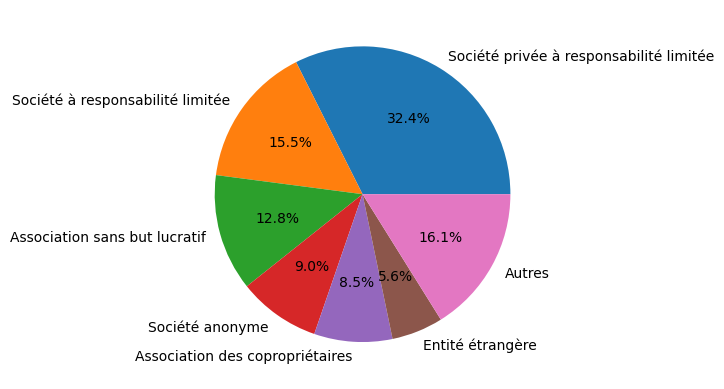

In [11]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
fig1, ax1 = plt.subplots()
ax1.pie(df_Q1T1['Total_Enterprise'], labels = df_Q1T1['Description'], autopct='%1.1f%%')
st.pyplot(fig1)

### Q2 GRAPH

In [12]:
# #Display the number of active company
st.markdown(f"<h1 style='text-align: center; color: darkblue;'>ACTIVE ENTERPRISES :  </h1>", unsafe_allow_html=True)
st.markdown(f"<h1 style='text-align: center; color: grey;'>{score_active_ent_prc}% ({score_active_ent})</h1>", unsafe_allow_html=True)
st.markdown("##")

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

### Q3 GRAPH

In [13]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = df_Q3["Description"]
sizes = df_Q3["count(EnterpriseNumber)"]

fig3, ax3 = plt.subplots()
ax3.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

st.pyplot(fig3)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

### Q4 GRAPH

In [46]:
fig, ax = plt.subplots()
ax.barh(df_Q4T1['sector'], df_Q4T1['age'])
f = lambda x: textwrap.fill(x.get_text(), 75)
ax.set_yticklabels(map(f, ax.get_yticklabels()))
fig.set_size_inches(18.5, 15.5, forward=True)
plt.title("average company's age in each sector")
plt.xlabel('Age in Years')
# plt.style.use('ggplot')
st.pyplot(fig)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)